# Fine-Tune Whisper For Akan ASR with HuggingFace Transformers

## Prepare Environment

In [3]:
import os

def count_files(directory):
    # List all files in the directory
    files = [f for f in os.listdir(directory) if os.path.isfile(os.path.join(directory, f))]
    return len(files)

# Replace 'your_directory_path' with the path to the folder
directory_path = "./random_2000_audio"
print(f"Number of files: {count_files(directory_path)}")



Number of files: 2000


In [4]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

/bin/bash: nvidia-smi: command not found


In [ ]:
import torch

if torch.cuda.is_available():
    print("GPU is available")
else:
    print("GPU is not available")

In [ ]:

print(torch.version.cuda)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

In [ ]:
%%capture

!pip install --upgrade --quiet pip
!pip install --upgrade --quiet datasets transformers accelerate deepspeed evaluate jiwer tensorboard gradio
# !pip install --upgrade --quiet optuna
# !pip install --upgrade --quiet bitsandbytes
# !pip install --upgrade --quiet huggingface_hub

In [ ]:
# connect to huggingFace

from huggingface_hub import notebook_login

notebook_login()


## Load Dataset

In [ ]:
from datasets import Dataset, Audio, DatasetDict, load_dataset
import pandas as pd

In [ ]:
# import preprocessed audio transcriptions
transcriptions_fpath = "./metadata-2000.csv"

transcriptions_df = pd.read_csv(f"{transcriptions_fpath}")

In [ ]:
transcriptions_df.head(5)

In [ ]:
transcriptions_df.shape

In [ ]:
#load custom audio files, downsample and split them for training

audio_fpath = "./random_2000_audio"

dataset = load_dataset("audiofolder", data_dir=f"{audio_fpath}")
dataset = dataset["train"].train_test_split(test_size=0.2)
dataset = dataset.cast_column("audio", Audio(sampling_rate=16000))

## Prepare Feature Extractor, Tokenizer and Data

In [ ]:
model_ckeckpoint = "openai/whisper-tiny"
model_task = "transcribe"
model_language = "Yoruba"
hf_repo = "nyarkssss/ty-nb-whisper2"

In [ ]:
from transformers import WhisperFeatureExtractor

feature_extractor = WhisperFeatureExtractor.from_pretrained(f"{model_ckeckpoint}")

### Load WhisperTokenizer

In [ ]:
from transformers import WhisperTokenizer

tokenizer = WhisperTokenizer.from_pretrained(f"{model_ckeckpoint}", language=f"{model_language}", task=f"{model_task}")

In [ ]:
tokenizer.save_pretrained(f"{hf_repo}", push_to_hub=True)

### Combine To Create A WhisperProcessor

In [ ]:
from transformers import WhisperProcessor

processor = WhisperProcessor.from_pretrained(f"{model_ckeckpoint}", language=f"{model_language}", task=f"{model_task}")

In [ ]:
processor.save_pretrained(f"{hf_repo}", push_to_hub=True)

### Prepare Data

Let's print the first example of the Common Voice dataset to see
what form the data is in:

In [ ]:
dataset['train'][0]

In [ ]:
# view training dataset

print("train_dataset.shape: ", dataset["train"], '\n')
print("test_dataset.shape: ", dataset["test"])

In [ ]:
# convert transcriptions pandas dataframe into a python dictionary :: {"file_name": "transcription"} for further processing

transcription_dict = pd.Series(transcriptions_df.transcription.values, index=transcriptions_df.file_name).to_dict()

In [ ]:
def prepare_data(dataset):

  # load audio
  audio = dataset['audio']

  # get corresponding audio transcriptions into dataset
  audio_file_name = audio["path"].split('/')[-1]
  transcription = transcription_dict.get(audio_file_name, "Transcription not found")
  # print(transcription)

  # attach transcriptions to audio
  dataset['sentence'] = transcription

  # extract log-mel spectogram features from audio array
  dataset["input_features"] = feature_extractor(audio["array"], sampling_rate=audio["sampling_rate"]).input_features[0]

  # encode target text into label ids
  dataset['labels'] = tokenizer(transcription).input_ids
  return dataset


In [ ]:
# load and convert audios log-mel spectrum, and append corresponding transcription
dataset = dataset.map(prepare_data, remove_columns=dataset.column_names["train"])

In [ ]:
# verify that the whisper tokenizer has been loaded properly
input_str = dataset["train"][0]["labels"]

# Convert list of token IDs to a string
input_str = tokenizer.decode(input_str, skip_special_tokens=True)
labels = tokenizer(input_str).input_ids
decoded_with_special = tokenizer.decode(labels, skip_special_tokens=False)
decoded_str = tokenizer.decode(labels, skip_special_tokens=True)

print(f"Input:                 {input_str}")
print(f"Decoded w/ special:    {decoded_with_special}")
print(f"Decoded w/out special: {decoded_str}")
print(f"Are equal:             {input_str == decoded_str}")

## Training and Evaluation

In [ ]:
from transformers import WhisperForConditionalGeneration

model = WhisperForConditionalGeneration.from_pretrained(f"{model_ckeckpoint}")

In [ ]:
# model generation config

model.generation_config.suppress_tokens = []
model.generation_config.task = "transcribe"
model.generation_config.language = "yoruba"
model.generation_config.forced_decoder_ids = None

# model config
model.config.use_cache = False

In [ ]:
from transformers import GenerationConfig
model.generation_config.save_pretrained(f"{hf_repo}", push_to_hub=True)

In [ ]:
# Push model's configuration to Hugging Face Hub

model.config.save_pretrained(f"{hf_repo}", push_to_hub=True)

### Define a Data Collator

In [ ]:
import torch

from dataclasses import dataclass
from typing import Any, Dict, List, Union

@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any
    decoder_start_token_id: int

    def __call__(self, features: List[Dict[str, Union[List[int], torch.Tensor]]]) -> Dict[str, torch.Tensor]:
        # split inputs and labels since they have to be of different lengths and need different padding methods
        # first treat the audio inputs by simply returning torch tensors
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        batch = self.processor.feature_extractor.pad(input_features, return_tensors="pt")

        # get the tokenized label sequences
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        # pad the labels to max length
        labels_batch = self.processor.tokenizer.pad(label_features, return_tensors="pt")

        # replace padding with -100 to ignore loss correctly
        labels = labels_batch["input_ids"].masked_fill(labels_batch.attention_mask.ne(1), -100)

        # if bos token is appended in previous tokenization step,
        # cut bos token here as it's append later anyways
        if (labels[:, 0] == self.decoder_start_token_id).all().cpu().item():
            labels = labels[:, 1:]

        batch["labels"] = labels

        return batch

### Evaluation Metrics

In [ ]:
import evaluate

metric = evaluate.load("wer")

In [ ]:
def compute_metrics(pred):
    pred_ids = pred.predictions
    label_ids = pred.label_ids

    # replace -100 with the pad_token_id
    label_ids[label_ids == -100] = tokenizer.pad_token_id

    # we do not want to group tokens when computing the metrics
    pred_str = tokenizer.batch_decode(pred_ids, skip_special_tokens=True)
    label_str = tokenizer.batch_decode(label_ids, skip_special_tokens=True)
    # .lower()

    wer = 100 * metric.compute(predictions=pred_str, references=label_str)

    return {"wer": wer}

### Define the Training Configuration

In the final step, we define all the parameters related to training. For more detail on the training arguments, refer to the Seq2SeqTrainingArguments [docs](https://huggingface.co/docs/transformers/main_classes/trainer#transformers.Seq2SeqTrainingArguments).

In [ ]:
from transformers import EarlyStoppingCallback

# defining early stopping criteria
early_stopping = EarlyStoppingCallback(early_stopping_patience=3)

In [ ]:
from transformers import Seq2SeqTrainingArguments

training_args = Seq2SeqTrainingArguments(
    output_dir=f"{hf_repo}",  
    per_device_train_batch_size=16,
    gradient_accumulation_steps=1,  
    learning_rate=6e-4, #6e-4
    warmup_steps=500,
    max_steps=4000,
    gradient_checkpointing=True,
    fp16=True,
    eval_strategy="steps",
    per_device_eval_batch_size=8,
    predict_with_generate=True,
    generation_max_length=225,
    save_steps=1000,
    eval_steps=1000,
    logging_steps=25,
    report_to=["tensorboard"],
    load_best_model_at_end=True,
    metric_for_best_model="wer",
    greater_is_better=False,
    push_to_hub=True,
    save_total_limit=1,
    adam_epsilon = 1e-6,
    adam_beta1 = 0.9,
    adam_beta2 = 0.98,

)

In [ ]:
from transformers import Seq2SeqTrainer

trainer = Seq2SeqTrainer(
    args=training_args,
    model=model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["test"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=processor.feature_extractor,
    callbacks=[early_stopping],
)

In [ ]:
processor.save_pretrained(f"{hf_repo}", push_to_hub=True)

### Training

In [ ]:

# train model
trainer.train()


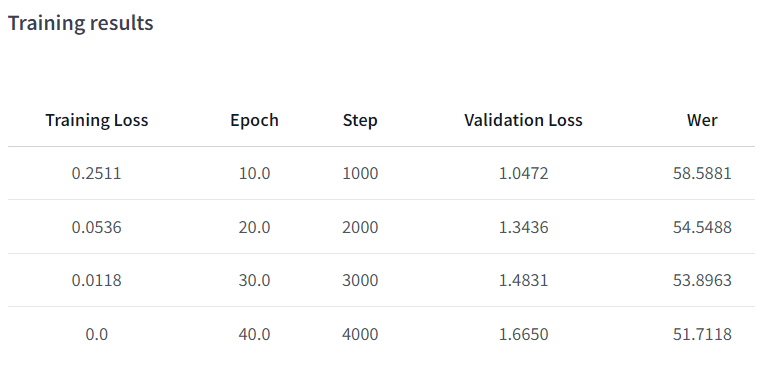

In [ ]:
# push model to hub
kwargs = {
    "dataset_tags": "speech_data_ghana_ug",
    "dataset": "Speech Data Ghana UG - Ghanaian Multilingual Sample Data",
    "language": "ak",
    "model_name": "Whisper Small Tiny",
    "finetuned_from": "openai/whisper-tiny",
    "tasks": "automatic-speech-recognition",
    "tags": "akan-whisper-tiny",
}

trainer.push_to_hub(**kwargs)